Understand the Dataset and Goal

Dataset: The Wisconsin Breast Cancer dataset is a classic binary classification problem. Here the goal is to predict whether a tumor is benign or malignant.

Features: The dataset typically contains 30 features derived from digitized images of fine needle aspirates (FNA) of breast masses. These features describe characteristics of cell nuclei, such as mean radius, texture, perimeter, etc.

Target: The target variable is the diagnosis (benign or malignant).

Objective: Overall goal is to build a machine learning model that accurately classifies new breast cancer cases. Hyperparameter optimization is a crucial step to achieve the best possible performance.

In [1]:
%pip install deap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from deap import base,creator,tools,algorithms
import pandas as pd

In [2]:
data = pd.read_csv("C:/Users/Utente/Desktop/BDS/FORGE_WEEKLY_CODE/07082025/Synthetic_data_Wiscon_cancer_dataset.csv")
data.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,19.318,21.61,126.66,1133.6,0.08633,0.10965,0.190756,0.111431,0.1884,0.06073,...,28.87,144.82,1421.4,0.12850,0.28104,0.584693,0.210785,0.3064,0.08724,M
1,13.194,11.80,85.03,501.7,0.09764,0.11818,0.074654,0.026992,0.2045,0.06507,...,15.59,92.55,618.8,0.13862,0.31884,0.190528,0.098769,0.3480,0.09263,B
2,9.104,14.93,58.01,246.3,0.10835,0.09520,0.027825,0.019091,0.1924,0.07006,...,23.66,67.05,339.2,0.14053,0.16558,0.074658,0.070532,0.2867,0.08641,B
3,13.775,22.65,90.22,609.8,0.10376,0.12046,0.095362,0.046752,0.2159,0.07298,...,32.21,98.22,700.5,0.13305,0.23207,0.135525,0.110046,0.2730,0.09003,B
4,16.435,15.02,102.23,886.4,0.05263,0.02643,0.008280,0.006243,0.1370,0.04996,...,18.44,117.81,1122.9,0.09840,0.04447,0.022537,0.030436,0.2270,0.05791,B


In [3]:
X = data.drop('Diagnosis', axis=1)
y = data['Diagnosis']

In [4]:
HYPERPARAMETER_SPACE = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [10]:
# Encode None as 0 for mutation
def encode_max_depth(val):
    return 0 if val is None else val

def decode_max_depth(val):
    return None if val == 0 else val

In [12]:
import random
# DEAP setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Generate individual
def generate_individual():
    individual = [
        random.choice(HYPERPARAMETER_SPACE['n_estimators']),
        encode_max_depth(random.choice(HYPERPARAMETER_SPACE['max_depth'])),
        random.choice(HYPERPARAMETER_SPACE['min_samples_split']),
        random.choice(HYPERPARAMETER_SPACE['min_samples_leaf'])
    ]
    return creator.Individual(individual)

toolbox.register("individual", generate_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

c:\Users\Utente\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Utente\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [13]:
# Fitness evaluation function
def evaluate_individual(individual):
    hyperparameters = {
        'n_estimators': individual[0],
        'max_depth': decode_max_depth(individual[1]),
        'min_samples_split': individual[2],
        'min_samples_leaf': individual[3]
    }
    model = RandomForestClassifier(**hyperparameters, random_state=42)
    score = np.mean(cross_val_score(model, X, y, cv=5, scoring='accuracy'))
    return (score,)

toolbox.register("evaluate", evaluate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxTwoPoint)

In [14]:
# Mutation bounds
toolbox.register(
    "mutate", 
    tools.mutUniformInt, 
    low=[
        min(HYPERPARAMETER_SPACE['n_estimators']),
        0,  # encoded None
        min(HYPERPARAMETER_SPACE['min_samples_split']),
        min(HYPERPARAMETER_SPACE['min_samples_leaf'])
    ],
    up=[
        max(HYPERPARAMETER_SPACE['n_estimators']),
        max(filter(None, HYPERPARAMETER_SPACE['max_depth'])),
        max(HYPERPARAMETER_SPACE['min_samples_split']),
        max(HYPERPARAMETER_SPACE['min_samples_leaf'])
    ],
    indpb=0.1
)

In [16]:
# Evolve
population, logbook = algorithms.eaSimple(
    population,
    toolbox,
    cxpb=0.5,
    mutpb=0.2,
    ngen=20,
    stats=stats,
    halloffame=hall_of_fame,
    verbose=True
)

gen	nevals	avg     	max     	min     
0  	50    	0.752582	0.762785	0.727682
1  	35    	0.757154	0.762785	0.745226
2  	31    	0.757616	0.762785	0.745241
3  	25    	0.759406	0.762785	0.745257
4  	35    	0.759859	0.762785	0.739947
5  	19    	0.760772	0.762785	0.739947
6  	37    	0.760782	0.762785	0.736438
7  	28    	0.762785	0.762785	0.762785
8  	26    	0.762118	0.762785	0.746949
9  	30    	0.761659	0.762785	0.745195
10 	34    	0.762223	0.762785	0.741655
11 	35    	0.762574	0.762785	0.755783
12 	27    	0.762399	0.762785	0.750474
13 	34    	0.762259	0.762785	0.74698 
14 	30    	0.762224	0.762785	0.752243
15 	25    	0.762434	0.762785	0.752259
16 	25    	0.762539	0.762785	0.750489
17 	22    	0.762399	0.762785	0.743456
18 	30    	0.762785	0.762785	0.762785
19 	28    	0.762046	0.762785	0.745195
20 	27    	0.762259	0.762785	0.74698 


In [17]:
# Show the best individual
best_individual = hall_of_fame[0]
best_hyperparams = {
    'n_estimators': best_individual[0],
    'max_depth': decode_max_depth(best_individual[1]),
    'min_samples_split': best_individual[2],
    'min_samples_leaf': best_individual[3]
}

In [18]:
print("\nBest Individual:")
print("Hyperparameters:", best_hyperparams)
print("Accuracy:", evaluate_individual(best_individual)[0])


Best Individual:
Hyperparameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}
Accuracy: 0.7627852817885422


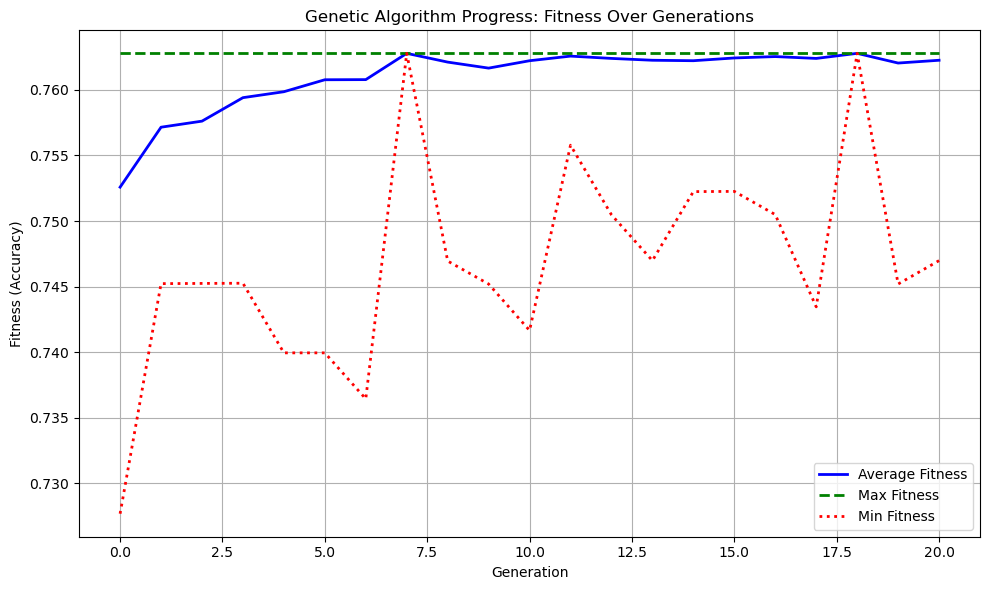

In [19]:
import matplotlib.pyplot as plt

# Extract statistics from the logbook
gen = logbook.select("gen")
avg_fitness = logbook.select("avg")
max_fitness = logbook.select("max")
min_fitness = logbook.select("min")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gen, avg_fitness, label="Average Fitness", color='blue', linewidth=2)
plt.plot(gen, max_fitness, label="Max Fitness", color='green', linestyle='--', linewidth=2)
plt.plot(gen, min_fitness, label="Min Fitness", color='red', linestyle=':', linewidth=2)

plt.xlabel("Generation")
plt.ylabel("Fitness (Accuracy)")
plt.title("Genetic Algorithm Progress: Fitness Over Generations")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
from sklearn.svm import SVC

HYPERPARAMETER_SPACE = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

In [21]:
# Map index to kernel
def decode_kernel(index):
    return HYPERPARAMETER_SPACE['kernel'][index]

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

c:\Users\Utente\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Utente\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [22]:
# Create individuals: index-based representation
def generate_individual():
    return creator.Individual([
        random.choice(HYPERPARAMETER_SPACE['C']),
        random.randint(0, len(HYPERPARAMETER_SPACE['kernel']) - 1),  # index for kernel
        random.choice(HYPERPARAMETER_SPACE['gamma'])
    ])

toolbox.register("individual", generate_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [23]:
# Evaluate
def evaluate_individual(ind):
    hyperparameters = {
        'C': ind[0],
        'kernel': decode_kernel(ind[1]),
        'gamma': ind[2]
    }

    # Only use gamma if kernel is not linear
    if hyperparameters['kernel'] == 'linear':
        model = SVC(C=hyperparameters['C'], kernel='linear', random_state=42)
    else:
        model = SVC(**hyperparameters, random_state=42)

    score = np.mean(cross_val_score(model, X, y, cv=5, scoring='accuracy'))
    return (score,)

toolbox.register("evaluate", evaluate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxTwoPoint)

In [25]:
# Mutation bounds
toolbox.register(
    "mutate",
    tools.mutUniformInt,
    low=[min(HYPERPARAMETER_SPACE['C']),
         0,
         min(HYPERPARAMETER_SPACE['gamma'])],
    up=[max(HYPERPARAMETER_SPACE['C']),
        len(HYPERPARAMETER_SPACE['kernel']) - 1,
        max(HYPERPARAMETER_SPACE['gamma'])],
    indpb=0.1
)

In [ ]:
# Run GA
population = toolbox.population(n=50)
hall_of_fame = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("max", np.max)
stats.register("min", np.min)

population, logbook = algorithms.eaSimple(
    population,
    toolbox,
    cxpb=0.5,
    mutpb=0.2,
    ngen=20,
    stats=stats,
    halloffame=hall_of_fame,
    verbose=True
)

In [ ]:
# Decode and print best solution
best_ind = hall_of_fame[0]
best_hyperparams = {
    'C': best_ind[0],
    'kernel': decode_kernel(best_ind[1]),
    'gamma': best_ind[2]
}
print("\nBest Individual (SVM):")
print("Hyperparameters:", best_hyperparams)
print("Accuracy:", evaluate_individual(best_ind)[0])

In [ ]:
# Plot fitness progression
gen = logbook.select("gen")
avg_fitness = logbook.select("avg")
max_fitness = logbook.select("max")
min_fitness = logbook.select("min")

plt.figure(figsize=(10, 6))
plt.plot(gen, avg_fitness, label="Average Fitness", color='blue', linewidth=2)
plt.plot(gen, max_fitness, label="Max Fitness", color='green', linestyle='--', linewidth=2)
plt.plot(gen, min_fitness, label="Min Fitness", color='red', linestyle=':', linewidth=2)
plt.xlabel("Generation")
plt.ylabel("Fitness (Accuracy)")
plt.title("GA Tuning Progress for SVM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()